In [45]:
import pytorch_lightning as pl
from pytorch_lightning import Trainer
import torchmetrics
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler
from tqdm import tqdm
from sklearn.datasets import fetch_20newsgroups
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from nltk.stem.snowball import SnowballStemmer
import logging
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)
from pytorch_lightning.callbacks import TQDMProgressBar
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np

Load data

In [2]:
train = fetch_20newsgroups(subset='train', shuffle=True)
test = fetch_20newsgroups(subset='test', shuffle=True)
print(dir(train))
print(len(train.data))
print("Target names:", train.target_names)
print("------------------------------------")
print("Label:", train.target_names[train.target[0]])
print("Text:", train.data[0][:250])
print("------------------------------------")

['DESCR', 'data', 'filenames', 'target', 'target_names']
11314
Target names: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
------------------------------------
Label: rec.autos
Text: From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the ot
------------------------------------


Preprocessing

In [3]:
stemmer = SnowballStemmer("english", ignore_stopwords=True)
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])
    
preprocess_pipeline = Pipeline([
    ("vect", StemmedCountVectorizer(stop_words="english", max_features=200)),
    ("tfidf", TfidfTransformer()),
])

In [4]:
train_data = preprocess_pipeline.fit_transform(train.data)

In [5]:
print(f"({len(train.data)}, {len(train.data[0])})")
print(train_data.shape)
train_labels = train.target
print(train_labels.shape)
print(train_labels[0])
number_of_labels = len(train.target_names)
print(number_of_labels)

(11314, 721)
(11314, 200)
(11314,)
7
20


Model definition

In [25]:
class DenseTextClassifier(pl.LightningModule):
    def __init__(self, network, loss_function, lr):
        super().__init__()
        self.network = network
        self.loss_function = loss_function
        self.lr = lr
        self.train_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=number_of_labels)
        self.val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=number_of_labels)
        self.history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    def forward(self, x):
        return self.network(x)

    def training_step(self, train_batch, _):
        inputs, targets = train_batch
        outputs = self(inputs)
        preds = torch.argmax(outputs, dim=1)

        train_loss = self.loss_function(outputs, targets)
        self.train_accuracy(preds, targets)
        self.log("train_loss", train_loss, prog_bar=True)
        self.log("train_acc", self.train_accuracy, prog_bar=True)
        return train_loss

    def validation_step(self, val_batch, _):
        inputs, targets = val_batch
        outputs = self(inputs)
        preds = torch.argmax(outputs, dim=1)

        val_loss = self.loss_function(outputs, targets)
        self.val_accuracy(preds, targets)
        self.log("val_loss", val_loss, prog_bar=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True)

    def on_train_epoch_end(self):
        self.history["train_loss"].append(self.trainer.callback_metrics["train_loss"])
        self.history["train_acc"].append(self.trainer.callback_metrics["train_acc"])

    def on_validation_epoch_end(self):
        self.history["val_loss"].append(self.trainer.callback_metrics["val_loss"])
        self.history["val_acc"].append(self.trainer.callback_metrics["val_acc"])

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.lr)

In [7]:
class SimpleNet(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, output_size)
        )

    def forward(self, x):
        return self.network(x)

Learning

In [8]:
class LitProgressBar(TQDMProgressBar):
    def init_validation_tqdm(self):
        bar = tqdm(disable=True)
        bar.close()
        return bar

In [46]:
num_epochs = 10
input_size = train_data.shape[1]
output_size = number_of_labels
batch_size = 64
lr = 0.001
loss_function = nn.CrossEntropyLoss()
k_folds = 5

data_tensor = torch.from_numpy(train_data.toarray()).float()
labels_tensor = torch.from_numpy(train_labels).long()
dataset = TensorDataset(data_tensor, labels_tensor)

kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
val_accuracies = []
for fold, (train_ids, val_ids) in enumerate(kfold.split(data_tensor)):
    print(f"Fold: {fold}")
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(train_ids), num_workers=7)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(val_ids), num_workers=7)

    network = SimpleNet(input_size, output_size)
    model = DenseTextClassifier(network=network, loss_function=loss_function, lr=lr)

    trainer = Trainer(max_epochs=num_epochs, callbacks=[LitProgressBar()], num_sanity_val_steps=0)
    trainer.fit(model, train_loader, val_loader)
    val_accuracies.append(model.history["val_acc"][-1])

average_val_accuracy = np.mean(val_accuracies)
print(f"Average Validation Accuracy: {average_val_accuracy}")

Fold: 0


Training: |          | 0/? [00:00<?, ?it/s]

Fold: 1


Training: |          | 0/? [00:00<?, ?it/s]

Fold: 2


Training: |          | 0/? [00:00<?, ?it/s]

Fold: 3


Training: |          | 0/? [00:00<?, ?it/s]

Fold: 4


Training: |          | 0/? [00:00<?, ?it/s]

Average Validation Accuracy: 0.5591298341751099


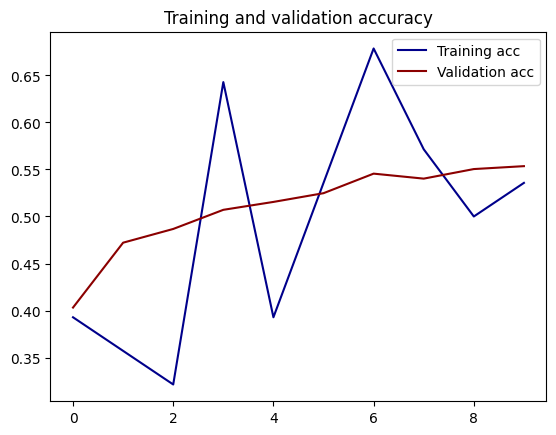

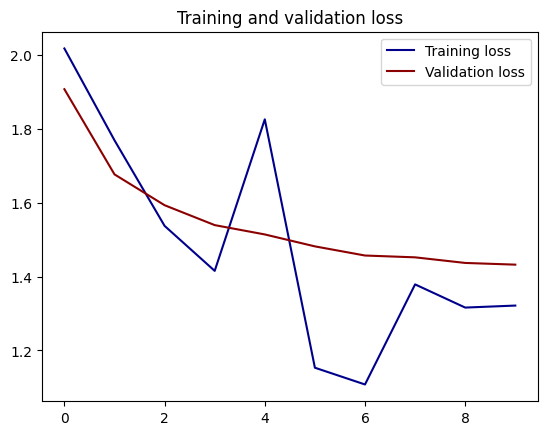

In [47]:
acc = model.history['train_acc']
val_acc = model.history['val_acc']
loss = model.history['train_loss']
val_loss = model.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc', color="darkblue")
plt.plot(epochs, val_acc, label='Validation acc', color="darkred")
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss', color="darkblue")
plt.plot(epochs, val_loss, label='Validation loss', color="darkred")
plt.title('Training and validation loss')
plt.legend()

plt.show()